In [1]:
# This notebook have built from this tutorial: https://github.com/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb
import numpy as np
import os

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Logger detectron2 (DEBUG)>

checking the version and if we have cuda available

In [2]:
from src.segmentation.framework_handlers.detectron2_handler import print_version_info

!nvcc --version
print_version_info()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:14:11_PDT_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0
torch:  1.9 ; cuda:  11.1
detectron2: 0.6


### Exporting the segments train and test dataset and regeister then to the detectron2 package

Remember!! when loading datasets from segments the images will be saved to the segments folder and the json coco annotations file will be save to the `saving_path` defined

In [3]:
from datetime import datetime

# Get the current date and time of the model training process
current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
current_time

'30-12-2023_12-21-22'

In [4]:
model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)
print(model_saving_path)

/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-21-22


In [5]:
from src.segmentation.framework_handlers.detectron2_handler import prepare_and_register_datasets

dataset_name_train = "etaylor/cannabis_patches_train"
dataset_name_test = "etaylor/cannabis_patches_test"
release_train = "v0.1"
release_test = "v0.1"
model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)

metadata_train, dataset_dicts_train, metadata_test, dataset_dicts_test = prepare_and_register_datasets(dataset_name_train, dataset_name_test, release_train, release_test)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 138/138 [00:07<00:00, 17.94it/s]


Initialized dataset with 138 images.
Exporting dataset. This may take a while...


100%|██████████| 138/138 [00:05<00:00, 23.78it/s]


Exported to ./export_coco-instance_etaylor_cannabis_patches_train_v0.1.json. Images in segments/etaylor_cannabis_patches_train/v0.1
Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 90/90 [00:06<00:00, 14.69it/s]


Initialized dataset with 90 images.
Exporting dataset. This may take a while...


100%|██████████| 90/90 [00:03<00:00, 25.42it/s]

Exported to ./export_coco-instance_etaylor_cannabis_patches_test_v0.1.json. Images in segments/etaylor_cannabis_patches_test/v0.1
WARNING [12/30 12:23:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 12:23:50 d2.data.datasets.coco]: Loaded 137 images in COCO format from segments/etaylor_cannabis_patches_train/annotations/export_coco-instance_etaylor_cannabis_patches_train_v0.1.json
WARNING [12/30 12:23:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 12:23:50 d2.data.datasets.coco]: Loaded 89 images in COCO format from segments/etaylor_cannabis_patches_test/annotations/export_coco-instance_etaylor_cannabis_patches_test_v0.1.json


plot train samples with annotations

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_train_samples

plot_train_samples(dataset_dicts_train, metadata_train, indices=[1,2])

Define the training params and to which model to fine tune

In [6]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

In [7]:
cfg = get_cfg()
cfg.OUTPUT_DIR = model_saving_path
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml"))
cfg.DATASETS.TRAIN = (dataset_name_train,)
cfg.DATASETS.TEST = ()
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"{model}.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [8]:
trainer.train() #Start the training process

NameError: name 'trainer' is not defined

In [ ]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
print(f"saving config to {config_yaml_path}")
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

saving config to /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_00-36-54/config.yaml


Code for loading model checkpoint and config

In [7]:
# from detectron2.config import get_cfg
# from detectron2.engine import DefaultPredictor

# # load the best model config and weights
# checkpoint_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/best_model/model_final.pth"
# config_yaml_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/best_model/config.yaml"
# cfg = get_cfg()
# # load config
# cfg.merge_from_file(config_yaml_path)
# # define predictor
# # load checkpoint
# cfg.MODEL.WEIGHTS = checkpoint_path
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
# predictor = DefaultPredictor(cfg)

Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/best_model/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[12/18 13:14:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/best_model/model_final.pth ...


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/30 01:00:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_00-36-54/model_final.pth ...


Plot model predictions on test set

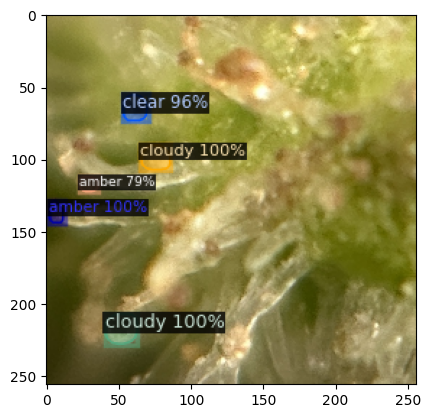

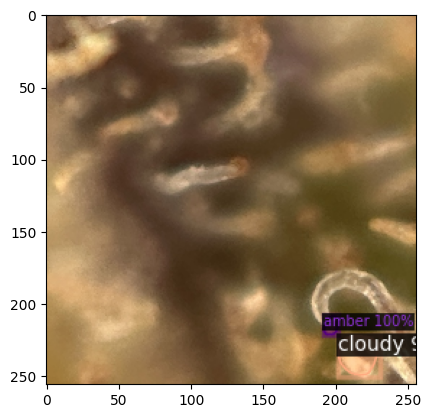

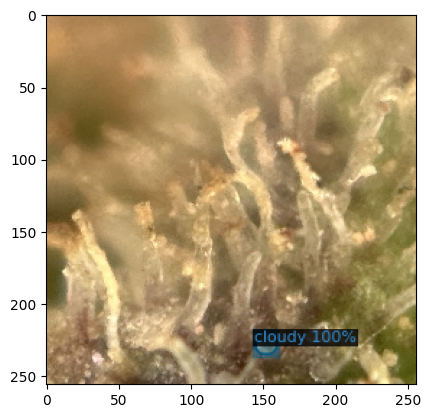

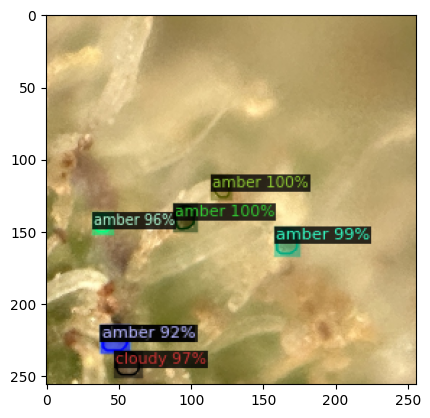

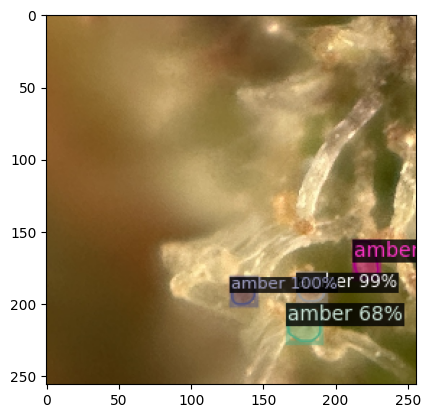

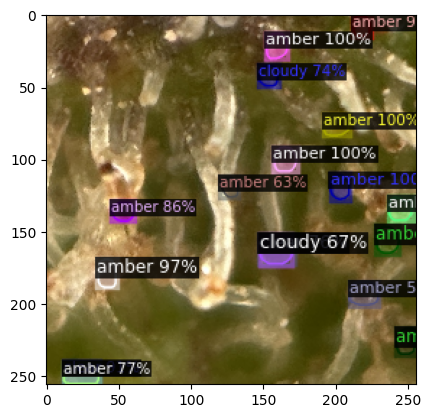

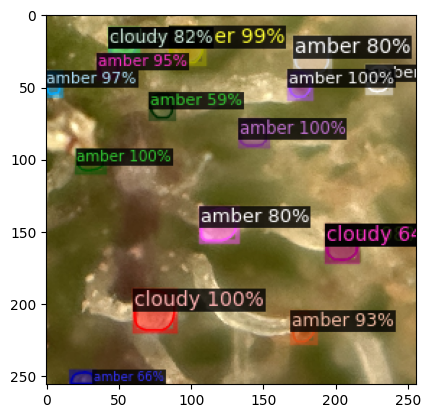

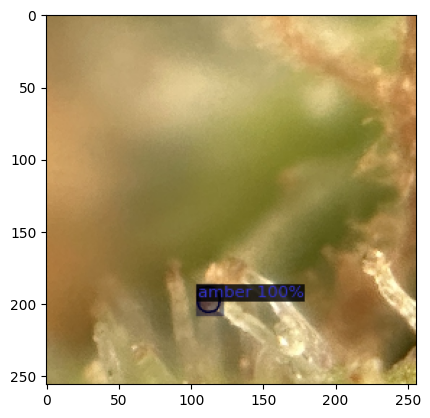

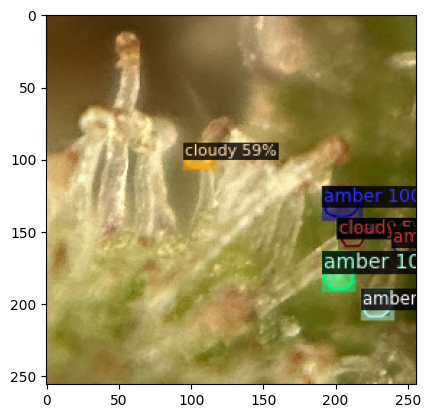

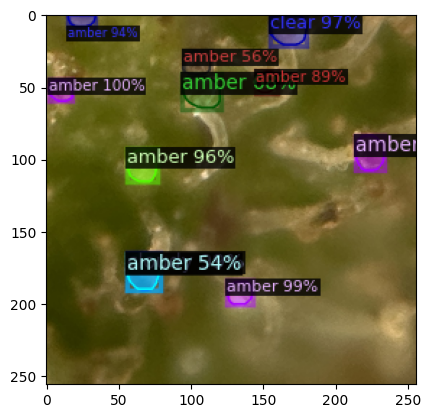

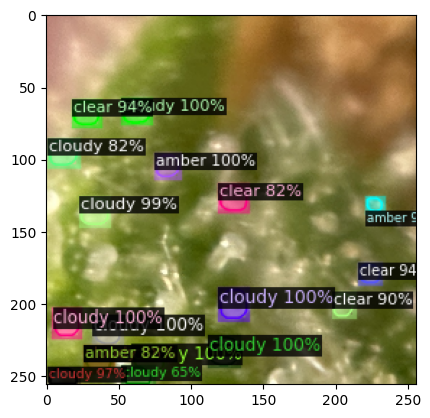

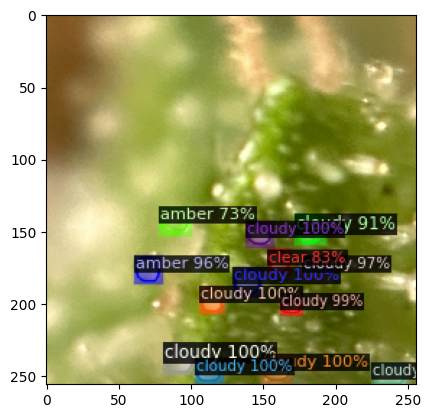

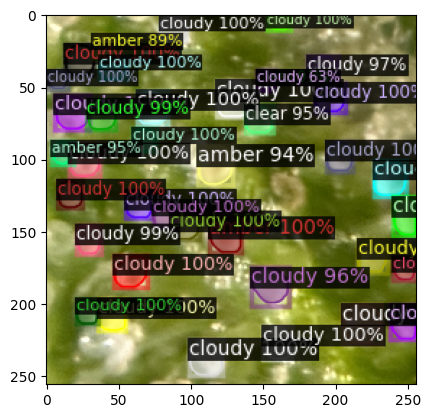

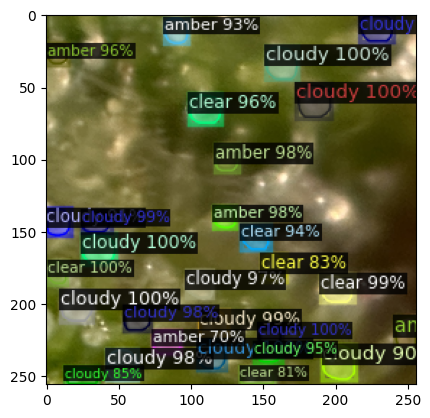

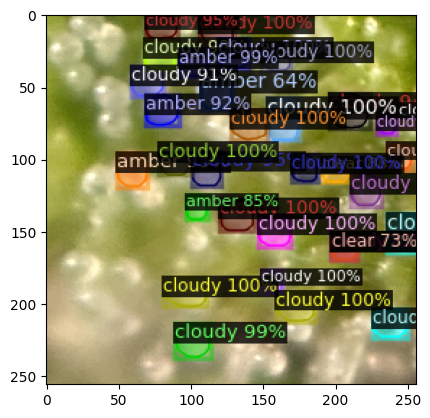

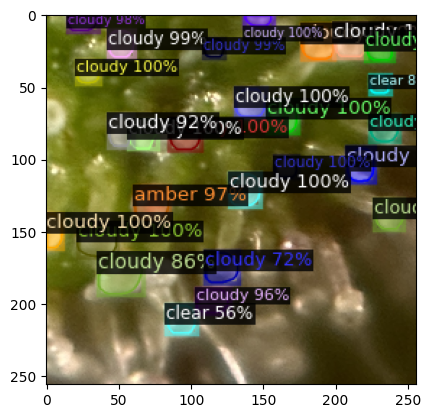

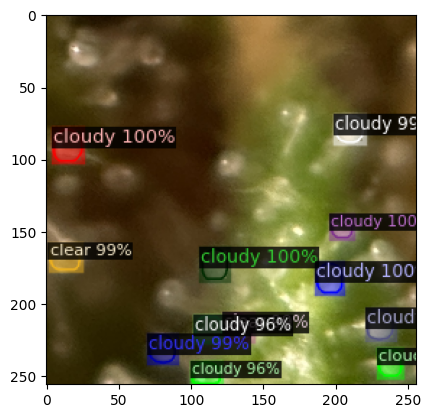

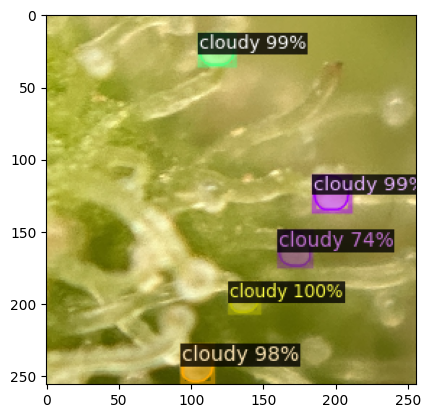

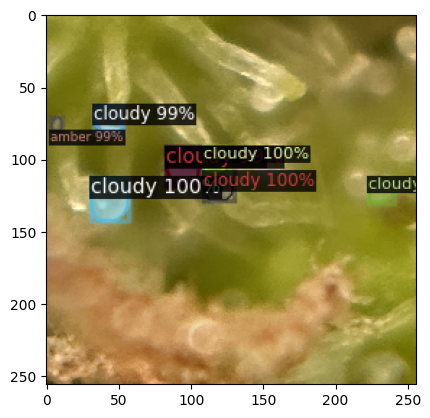

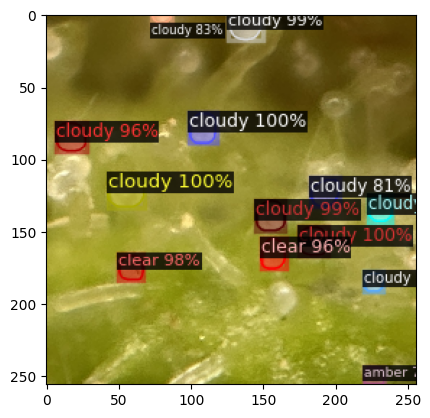

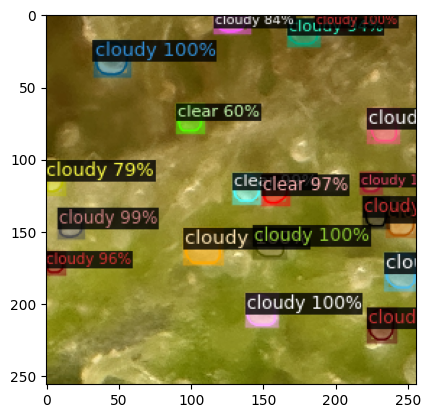

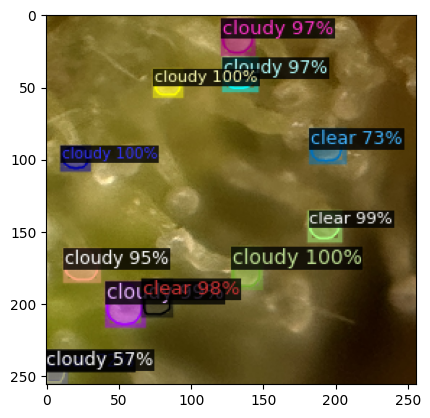

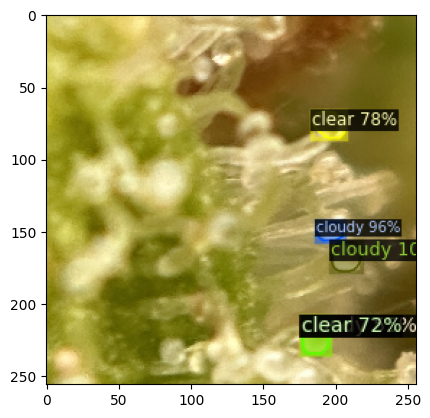

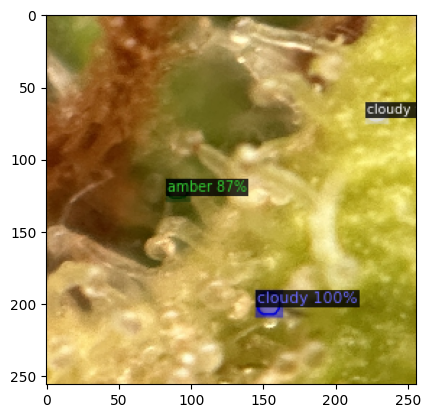

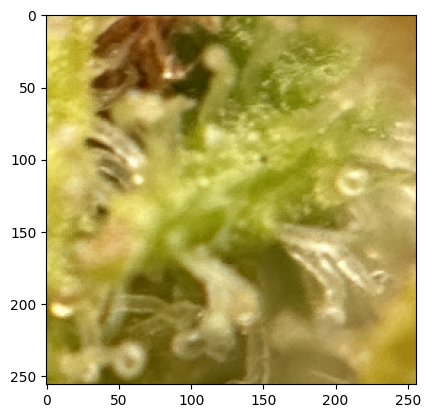

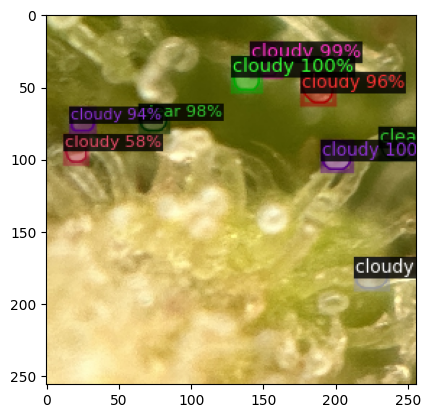

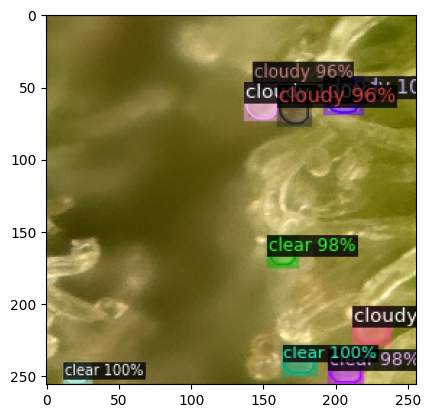

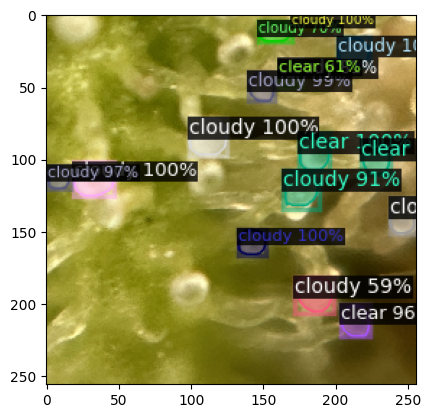

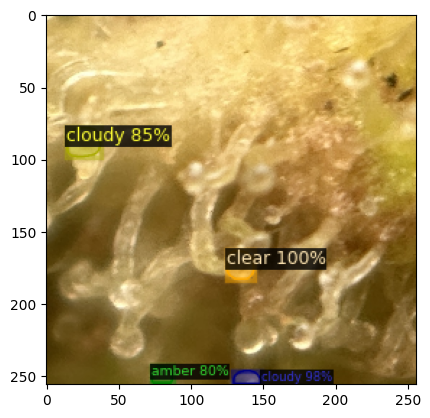

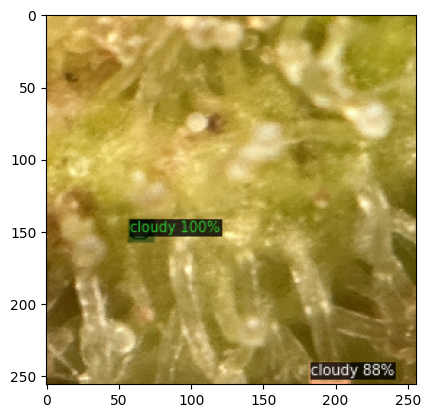

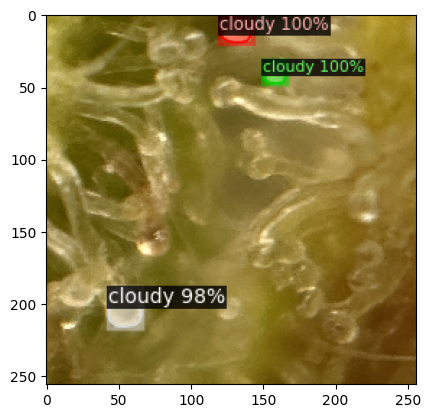

In [17]:
from src.segmentation.framework_handlers.detectron2_handler import plot_test_predictions

plot_test_predictions(dataset_dicts_test, metadata_test, predictor)

#### Register newtest set and evaluate metrics

In [24]:
# Register new test set
from src.segmentation.framework_handlers.detectron2_handler import convert_segments_to_coco_format
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

dataset_name_test = "etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285"
release_test = "v0.2"

# Convert segments dataset to coco format for testing dataset
_, test_export_json_path, test_saved_images_path = convert_segments_to_coco_format(
    dataset_name=dataset_name_test, 
    release_version=release_test, 
)

register_coco_instances(dataset_name_test, {}, test_export_json_path, test_saved_images_path)

metadata_test = MetadataCatalog.get(dataset_name_test)
dataset_dicts_test = DatasetCatalog.get(dataset_name_test)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Initialized dataset with 15 images.
Exporting dataset. This may take a while...


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]

Exported to ./export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json. Images in segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/v0.2
WARNING [12/30 01:19:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 01:19:25 d2.data.datasets.coco]: Loaded 15 images in COCO format from segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/annotations/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json


Evaluate the performance of the trained model on the test dataset using the `COCOEvaluator`

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import evaluate_model_on_dataset
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import json

evaluator = COCOEvaluator(dataset_name_test, output_dir=os.path.join(cfg.OUTPUT_DIR, dataset_name_test))
val_loader = build_detection_test_loader(cfg, dataset_name_test)
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)
os.mkdir(os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test)))
eval_results_saving_path = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test), "evaluation_results.json")
# Save the eval_results dictionary to a JSON file
with open(eval_results_saving_path, 'w') as file:
    json.dump(eval_results, file, indent=4)

WARNING [12/30 01:19:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/30 01:19:34 d2.data.datasets.coco]: Loaded 15 images in COCO format from segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/annotations/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json
[12/30 01:19:34 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  trichome  | 0            |   clear    | 30           |   cloudy   | 128          |
|   amber    | 12           |            |              |            |              |
|   total    | 170          |            |              |            |              |
[12/30 01:19:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [Resize

add a new dataset to segments and predict annotations using the model trained

In [15]:
from src.annotation_handling.segmentsai_handler import SegmentsAIHandler
from src.pipelines import model_assist_label_pipeline as pipe 
import config
import time
from segments import SegmentsDataset

segmentsai_handler = SegmentsAIHandler()


In [16]:
from src.segmentation.framework_handlers.detectron2_handler import convert_coco_to_segments_format


# New dataset to upload
image_name = "IMG_2155"
week = 'week9'
zoom_type = '3xr'
release = "v0.1"
nir_username = "Nirmalka"
dorin_username = "dorins"
collaborator = dorin_username

# Create a new test dataset for the specified image, week, and zoom type
test_dataset = pipe.create_new_test_dataset(image_name, config.WEEKS_DIR[week], config.ZOOM_TYPES_DIR[zoom_type], single_category=False)
# # Get the absolute path to the processed image
abs_images_path = f"{config.get_processed_cannabis_image_path(week, zoom_type)}/{image_name}"
raw_images_path = f"{config.get_raw_image_path(week, zoom_type)}/{image_name}.JPG"

# Upload the images that are not annotated to the dataset
segmentsai_handler.upload_single_image(test_dataset, raw_images_path) # upload the raw image path
segmentsai_handler.upload_images(test_dataset, abs_images_path)

description = "upload predictions to dataset."
segmentsai_handler.client.add_release(test_dataset, release, description)
print("Waiting 5 seconds that the release is created...")
time.sleep(5)
test_release = segmentsai_handler.client.get_release(test_dataset, "v0.1")
print(test_release)

# Add collaborator to the dataset
segmentsai_handler.client.add_dataset_collaborator(
    dataset_identifier=test_dataset,
    username=collaborator
)

test_dataset_instance = SegmentsDataset(test_release)

for sample in test_dataset_instance:
    # Generate label predictions
    image = np.array(sample["image"])
    # Change RGB (PIL) to BGR (OpenCV)
    cv2_image = image[:, :, ::-1]
    outputs = predictor(cv2_image)
    
    segmentation_bitmap, annotations = convert_coco_to_segments_format(cv2_image, outputs)
    segmentsai_handler.upload_annotation_for_sample(sample['uuid'], segmentation_bitmap, annotations)

name='cannabis_patches_week9_15_06_2023_3x_regular_IMG_2155' full_name='etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2155' cloned_from=None description='cannabis patches week=week9_15_06_2023 zoom_type=3x_regular of image=IMG_2155.' category='other' public=False owner=Owner(username='etaylor', created_at='2022-12-28T12:53:18Z', email=None) created_at='2023-12-29T23:05:59.592094Z' enable_ratings=False enable_skip_labeling=True enable_skip_reviewing=False enable_save_button=False enable_label_status_verified=False enable_same_dimensions_track_constraint=False enable_interpolation=True task_type='segmentation-bitmap' label_stats=LabelStats(REVIEWED=None, REVIEWING_IN_PROGRESS=None, LABELED=None, LABELING_IN_PROGRESS=None, REJECTED=None, PRELABELED=None, SKIPPED=None, VERIFIED=None, UNLABELED=None, TOTAL=None) labeling_inactivity_timeout_seconds=None samples_count=0 collaborators_count=None task_attributes=TaskAttributes(format_version='0.1', categories=[TaskAttributeCategory(n

100%|██████████| 10/10 [00:00<00:00, 34.26it/s]


Initialized dataset with 10 images.


In [88]:
from src.segmentation.framework_handlers.detectron2_handler import convert_coco_to_segments_format
test_dataset_instance = SegmentsDataset(test_release)

for sample in test_dataset_instance:
    # Generate label predictions
    image = np.array(sample["image"])
    # Change RGB (PIL) to BGR (OpenCV)
    cv2_image = image[:, :, ::-1]
    outputs = predictor(cv2_image)
    
    segmentation_bitmap, annotations = convert_coco_to_segments_format(cv2_image, outputs)
    segmentsai_handler.upload_annotation_for_sample(sample['uuid'], segmentation_bitmap, annotations)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 12/12 [00:00<00:00, 142.88it/s]

Initialized dataset with 12 images.


In [ ]:
# TODO: encapsulate the statistics calculations for the predictions to a function
# TODO:start saving evaluation results and compare with different models and hyper params

#### Segment images and save object level information into a csv file.



In [11]:
from src.segmentation.framework_handlers.detectron2_handler import extract_object_info_to_csv

dataset_directory = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753" 
input_images_directory = os.path.join(dataset_directory, "v0.1")
csv_file_name = "detected_objects.csv"
output_csv_path = os.path.join(dataset_directory,csv_file_name)

extract_object_info_to_csv(input_images_directory, output_csv_path, predictor, metadata_train)

'Object-level information saved to CSV file at /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753/detected_objects.csv'

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_class_statistics

plot_class_statistics(output_csv_path, metadata_train)

/tmp/ipykernel_24632/3811209441.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


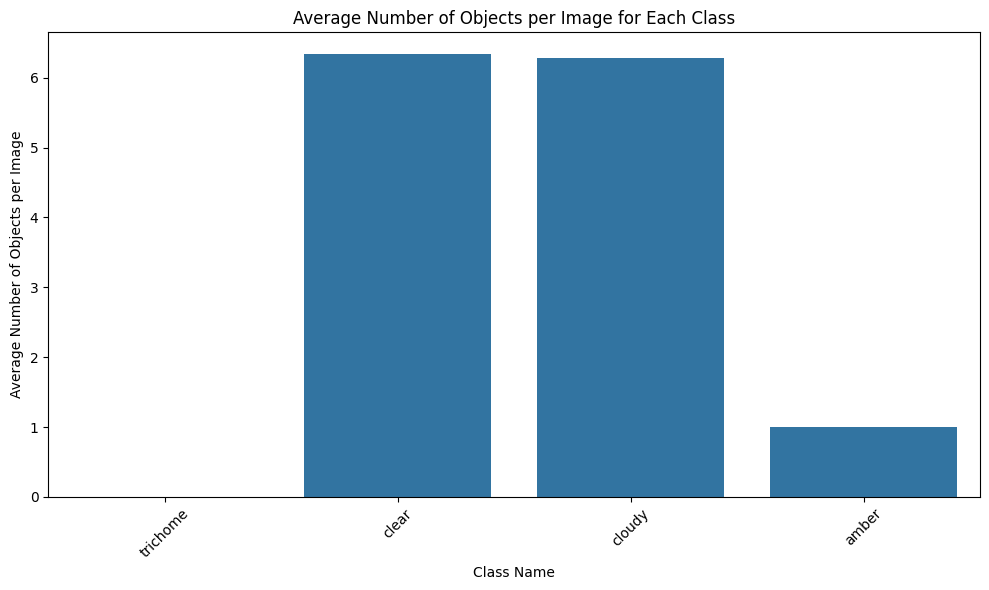

/tmp/ipykernel_24632/3811209441.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


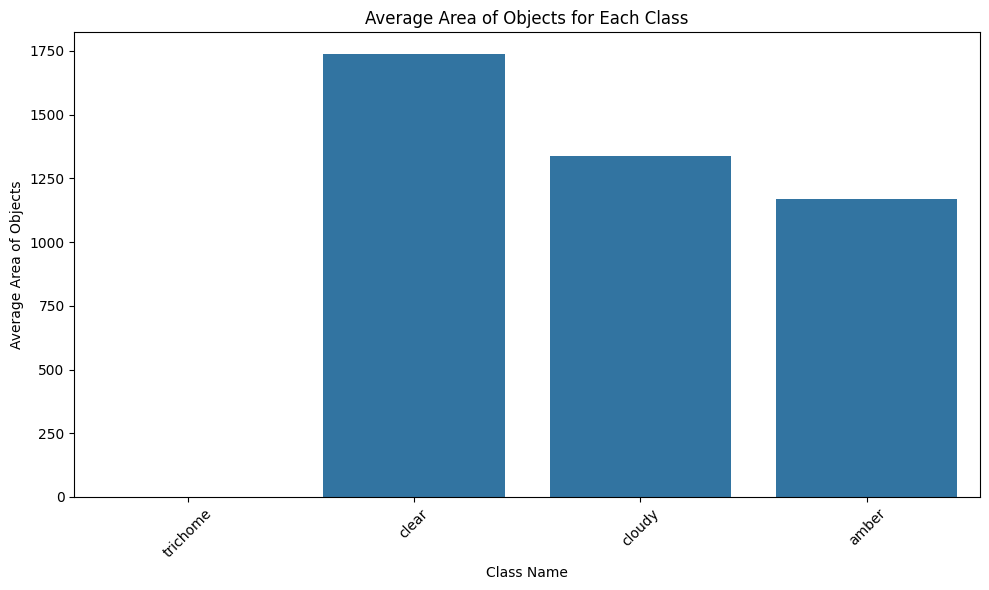

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(output_csv_path)

# Get class names from train_metadata.thing_classes
class_names = metadata_train.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()
